# Portfolio Optimization with Factor Modeling

This project demonstrates how to build a stock portfolio optimization engine using **factor modeling**, a popular approach in quantitative finance. Specifically, we use a **multi-factor model** including the Fama-French 3 factors and a **momentum (UMD)** factor to:

- Estimate expected stock returns
- Model factor risk exposures via time-series regression
- Perform **rolling portfolio optimization** using mean-variance theory
- Compare optimized portfolios with simple equal-weight benchmarks
- Visualize performance over time

Factor modeling is a way of understanding **why stocks move the way they do**, based on broad economic themes or characteristics (called "factors") that influence prices. Instead of picking stocks at random or by gut feeling, we use **data-driven insights** to decide which stocks are likely to perform well — and why.

---

## What Are Factors?

**Factors** are characteristics that explain the differences in returns across stocks. Think of them like hidden forces that affect how stocks behave.

We use four main factors in this project:

### 1. **Market Risk (Mkt-RF)**  
> Stocks tend to rise or fall with the overall market.  
> This factor measures how much a stock moves with the general market.

```
Visual: Market factor = Market return - Risk-free rate
```
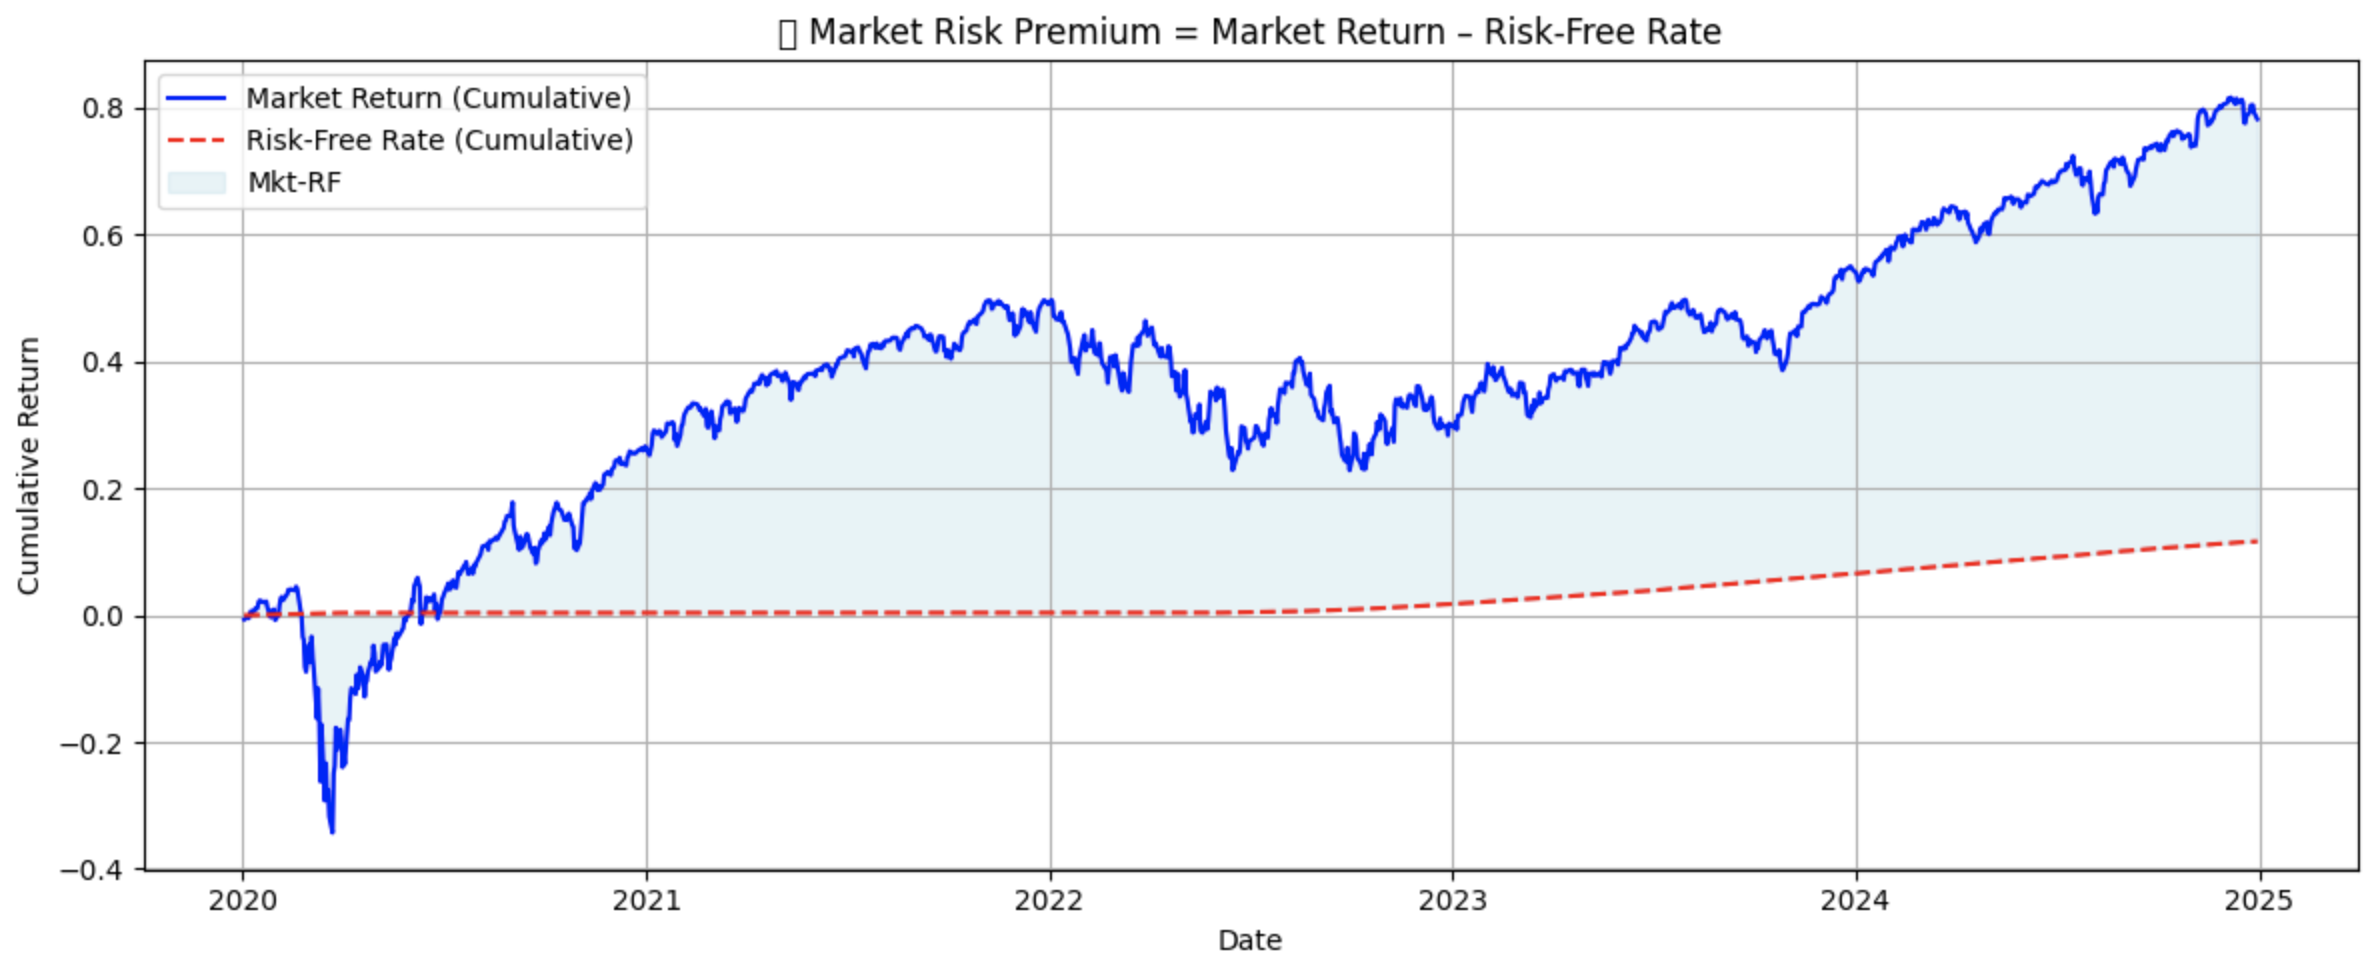

---

### 2. **Size Factor (SMB: Small Minus Big)**  
> Smaller companies often grow faster and offer more return (with more risk) than large companies.  
> This factor measures the return advantage of small-cap stocks over big ones.

```
Visual: SMB = Return(Small Stocks) - Return(Big Stocks)
```
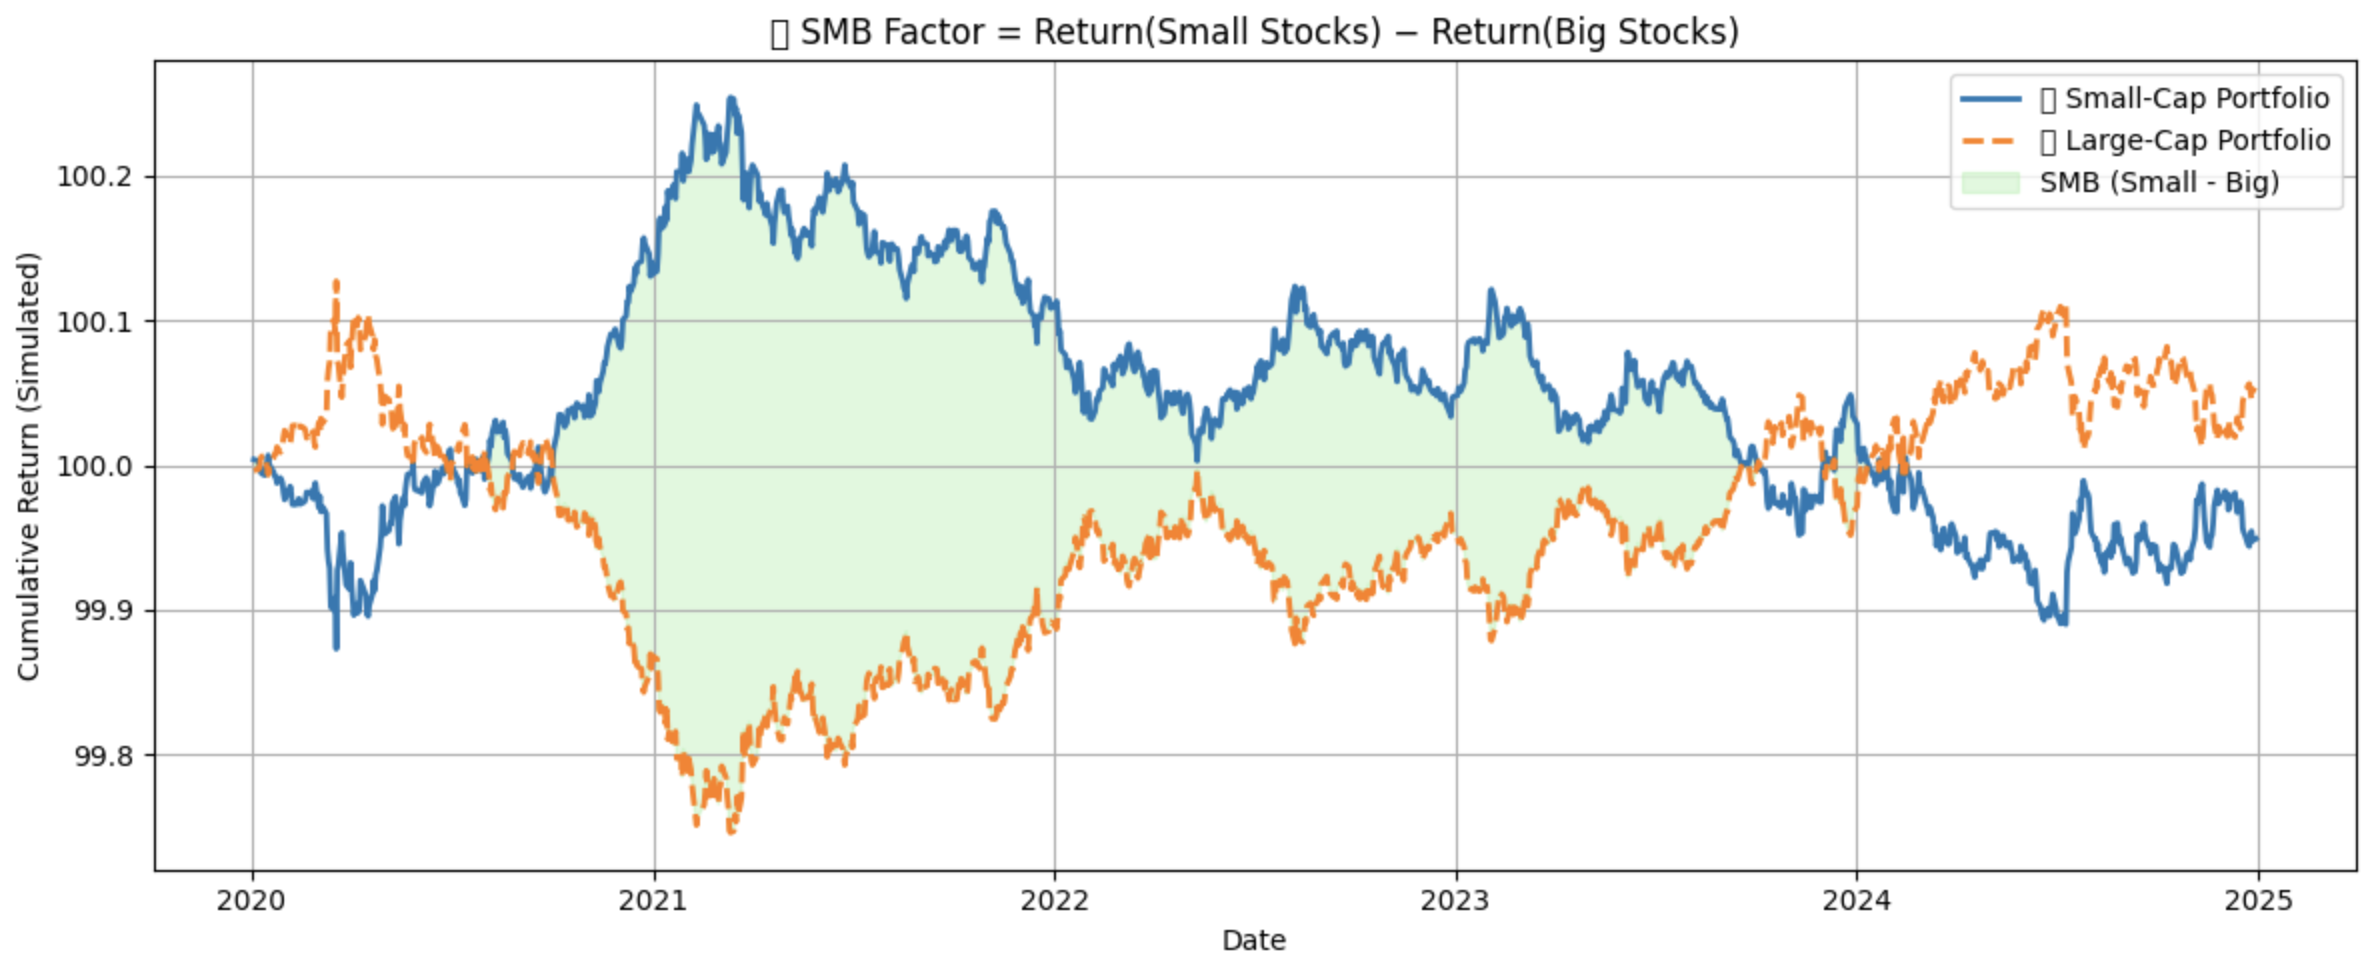
---

### 3. **Value Factor (HML: High Minus Low)**  
> Value stocks (cheap based on book value) have historically outperformed growth stocks.  
> This factor measures how much investors are rewarded for choosing undervalued companies.

```
Visual: HML = Return(High book-to-market) - Return(Low book-to-market)
```
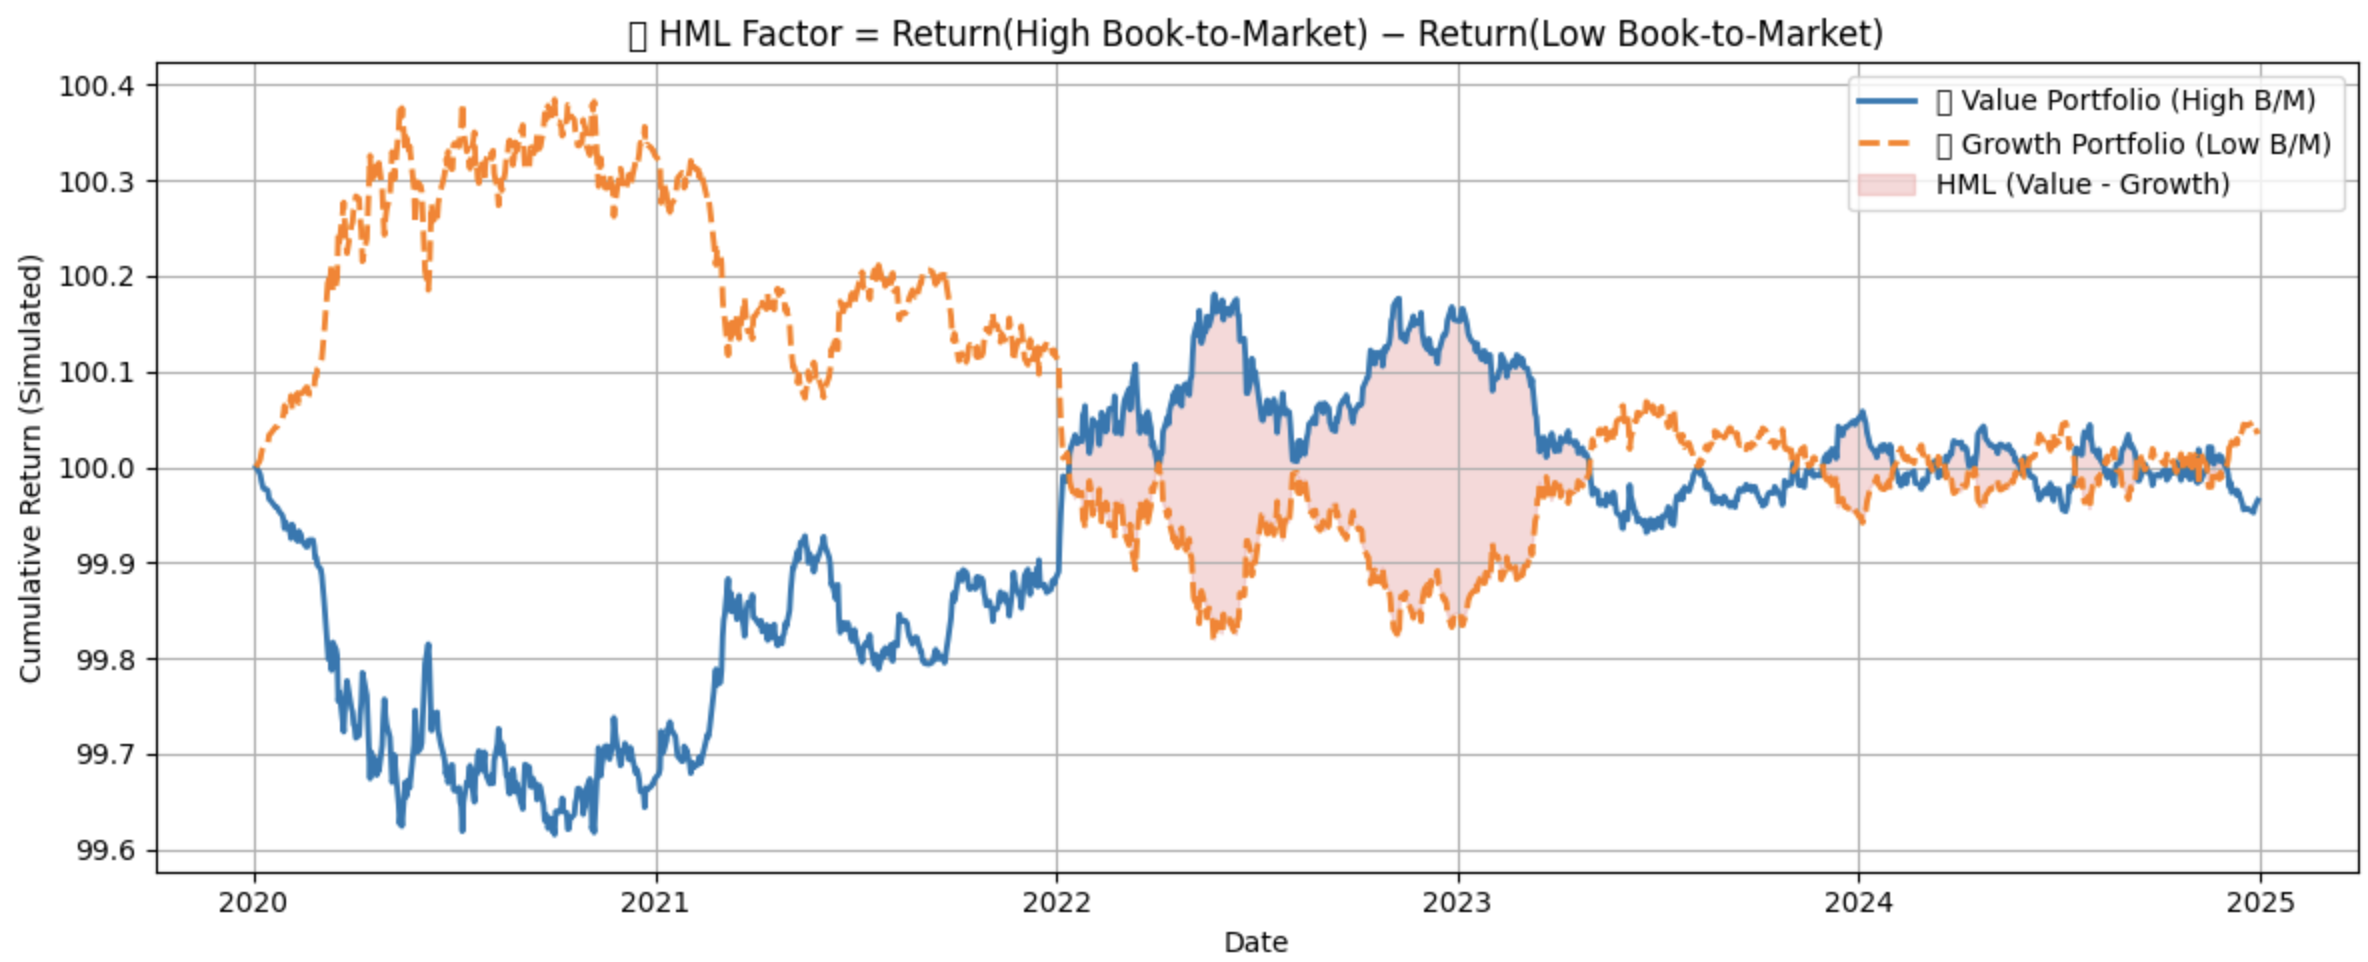

---

### 4. **Momentum Factor (MOM / UMD: Up Minus Down)**  
> Stocks that have performed well recently tend to continue performing well in the short term.  
> This factor captures the tendency of winners to keep winning.

```
Visual: MOM = Return(Recent Winners) - Return(Recent Losers)
```

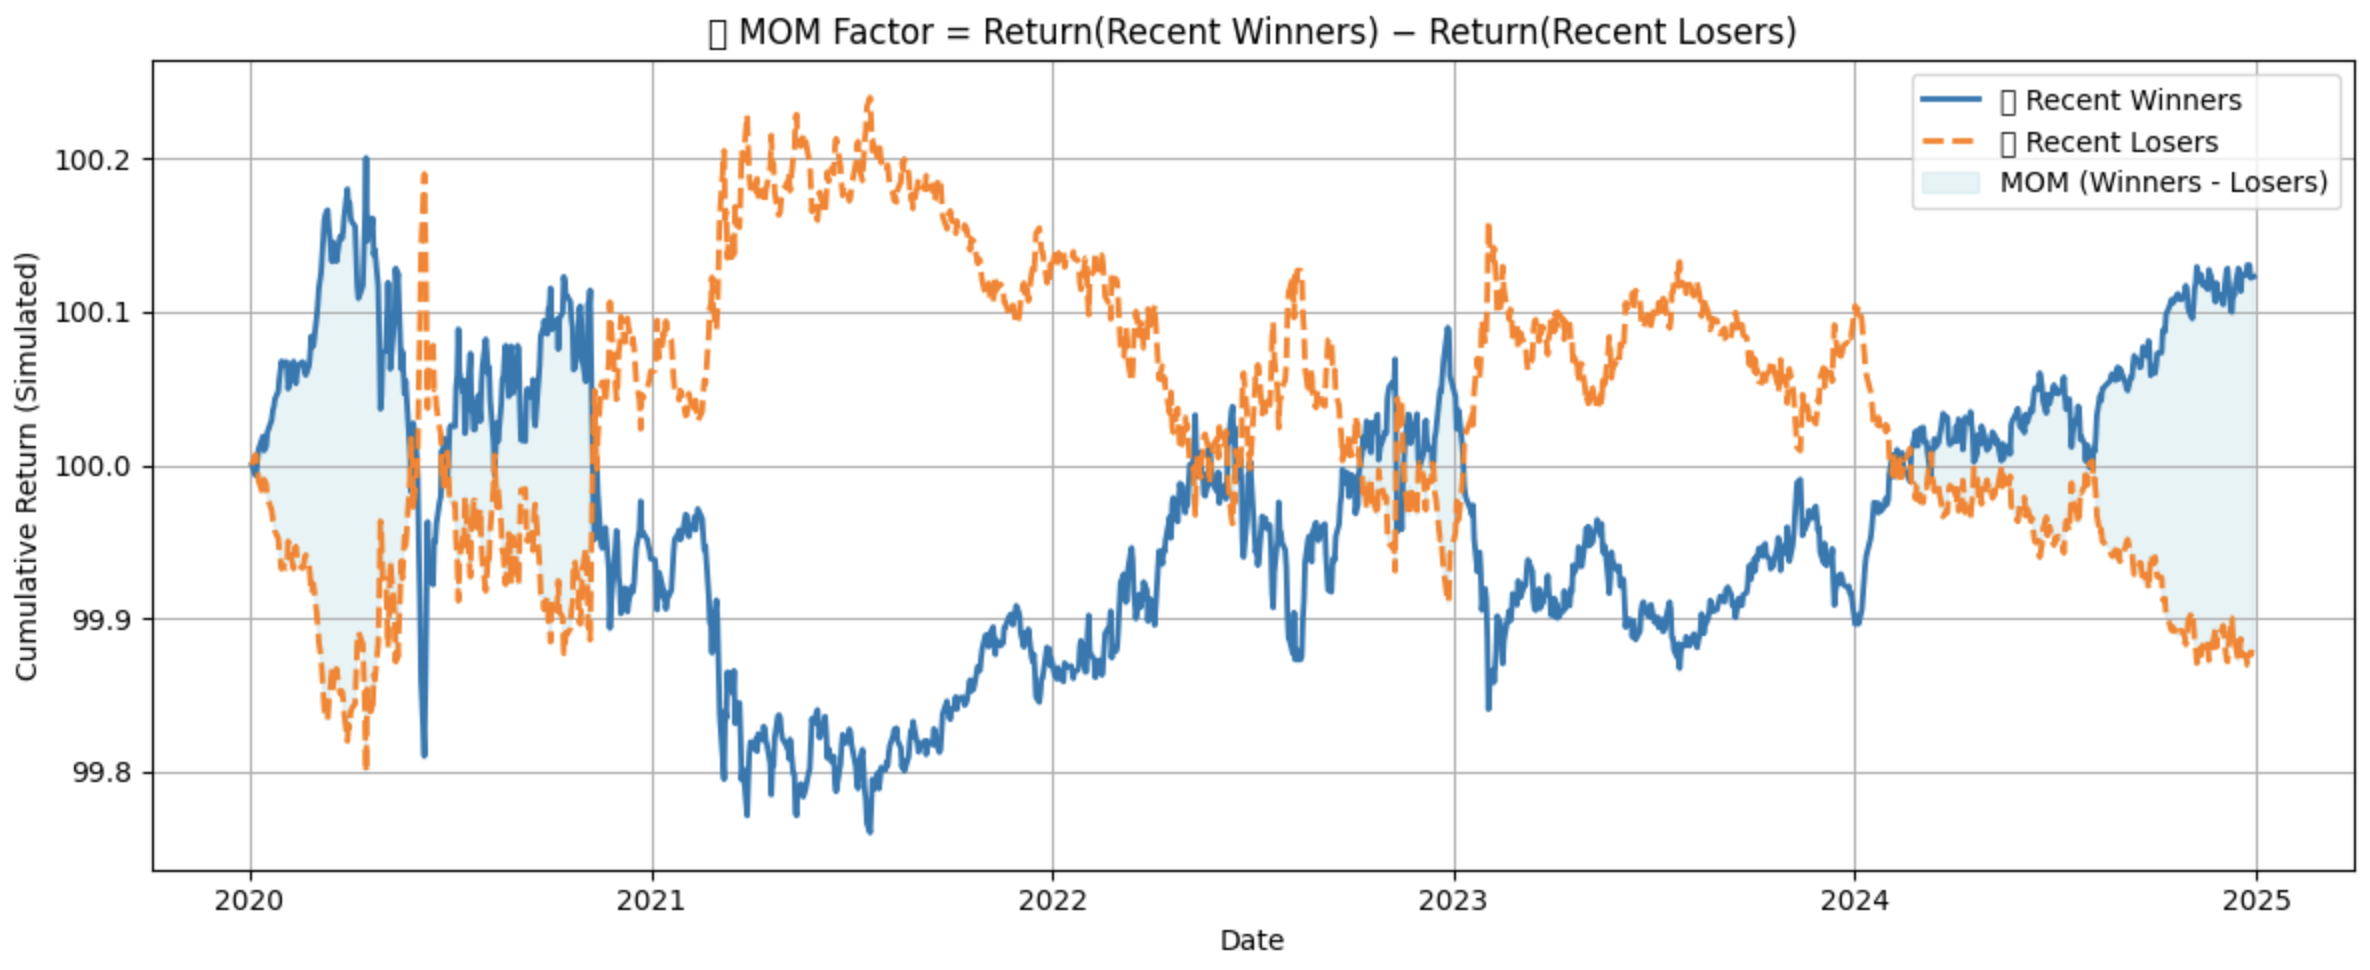

---

## Project Objective

We use these factors to:

- **Estimate how sensitive each stock is** to these forces (called "beta")
- **Forecast future returns** based on those sensitivities
- **Build an optimized portfolio** that balances risk and return
- **Rebalance the portfolio monthly** to adapt to changing market conditions

By the end, you'll see how data, math, and finance come together to make smarter investing decisions.



> We formulate and solve a mean-variance optimization problem using `cvxpy`. The goal is to maximize expected return adjusted for portfolio variance.

# Step 1: Download Stock Price Data

> We select a few well-known tech stocks and fetch their closing prices using the `yfinance` library. These will form the universe of our portfolio.

In [68]:
import warnings
warnings.filterwarnings("ignore")

In [69]:
import yfinance as yf
import pandas as pd

tickers = ['AAPL', 'MSFT', 'GOOGL', 'META', 'AMZN']
start_date = "2020-01-01"
end_date = "2024-12-31"

data = yf.download(tickers, start=start_date, end=end_date)['Close']
data = data.dropna()
data.head()

[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2020-01-02,72.620850,94.900497,68.026031,208.635422,153.042282
2020-01-03,71.914803,93.748497,67.670143,207.531464,151.136673
2020-01-06,72.487854,95.143997,69.473846,211.440048,151.527298
2020-01-07,72.146935,95.343002,69.339645,211.897522,150.145767
2020-01-08,73.307510,94.598503,69.833183,214.045746,152.537292


##  Step 2: Calculate Daily Returns

> Converting prices to returns allows us to model the statistical properties of asset returns, which are more stationary and suitable for regression and optimization.

In [70]:
returns = data.pct_change().dropna()
returns.head()

Ticker,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2020-01-03,-0.009722,-0.012139,-0.005232,-0.005291,-0.012452
2020-01-06,0.007968,0.014886,0.026654,0.018834,0.002585
2020-01-07,-0.004703,0.002092,-0.001932,0.002164,-0.009117
2020-01-08,0.016086,-0.007809,0.007118,0.010138,0.015928
2020-01-09,0.021241,0.004799,0.010498,0.014311,0.012493


## Step 3: Load Fama-French 3-Factor and Momentum Data

> We retrieve macroeconomic factor data from the Kenneth French Data Library via `pandas_datareader`. This includes market, size, value, and momentum factors.

In [71]:
import pandas_datareader.data as web

# Get the standard 3-factor data
ff_factors = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start_date)[0]

# Get the momentum factor (UMD)
momentum_factors = web.DataReader('F-F_Momentum_Factor_daily', 'famafrench', start_date)[0]

# Convert indexes to datetime
ff_factors.index = pd.to_datetime(ff_factors.index)
momentum_factors.index = pd.to_datetime(momentum_factors.index)

# Convert percent to decimal
ff_factors = ff_factors / 100
momentum_factors = momentum_factors / 100

# Join the UMD (momentum) column
ff_factors['MOM'] = momentum_factors['Mom']

# Filter to match returns index
ff_factors = ff_factors.loc[returns.index]

ff_factors.head()


,Mkt-RF,SMB,HML,RF,MOM
Date,,,,,
2020-01-03,-0.0067,0.0038,0.0001,0.00006,0.0001
2020-01-06,0.0036,-0.0007,-0.0055,0.00006,-0.0067
2020-01-07,-0.0019,-0.0001,-0.0026,0.00006,0.0001
2020-01-08,0.0047,-0.0007,-0.0064,0.00006,0.0094
2020-01-09,0.0065,-0.0063,-0.0048,0.00006,0.0073


## Step 4: Estimate Factor Loadings (Regression)

Use time-series regression to estimate factor betas (exposures) for each stock.

In [72]:
import statsmodels.api as sm

betas = {}

for ticker in returns.columns:
    y = returns[ticker] - ff_factors['RF']
    X = sm.add_constant(ff_factors[['Mkt-RF', 'SMB', 'HML', 'MOM']])
    model = sm.OLS(y, X).fit()
    betas[ticker] = model.params

betas_df = pd.DataFrame(betas).T
betas_df.columns = ['alpha', 'beta_mkt', 'beta_smb', 'beta_hml', 'beta_mom']
betas_df

,alpha,beta_mkt,beta_smb,beta_hml,beta_mom
AAPL,0.000448,1.169829,-0.309909,-0.351443,0.057692
AMZN,0.000271,1.041817,-0.197047,-0.752301,-0.139095
GOOGL,0.000344,1.100093,-0.268098,-0.396104,-0.107299
META,0.000466,1.252288,-0.252310,-0.691709,-0.191020
MSFT,0.000246,1.175765,-0.419870,-0.434945,0.038199



> For each stock, we perform a regression of its excess returns against the factors to estimate its sensitivity (beta) to each risk factor.

## Step 5: Estimate Expected Returns

> Using the estimated betas and the historical average of each factor premium, we forecast expected returns for each stock.

In [73]:
factor_premiums = ff_factors[['Mkt-RF', 'SMB', 'HML', 'MOM']].mean()
expected_rf = ff_factors['RF'].mean()

expected_excess_returns = (
    betas_df[['beta_mkt', 'beta_smb', 'beta_hml', 'beta_mom']].values @ factor_premiums.values
) + betas_df['alpha'].values

expected_returns = expected_rf + expected_excess_returns

## Step 6: Estimate Covariance Matrix

> We compute the empirical covariance matrix of the asset returns. This captures the risk interactions among stocks as an input to portfolio optimization.

In [74]:
cov_matrix = returns.cov()
cov_matrix

Ticker,AAPL,AMZN,GOOGL,META,MSFT
Ticker,,,,,
AAPL,0.000398,0.000268,0.000265,0.000318,0.000287
AMZN,0.000268,0.000514,0.000300,0.000390,0.000295
GOOGL,0.000265,0.000300,0.000419,0.000371,0.000294
META,0.000318,0.000390,0.000371,0.000801,0.000337
MSFT,0.000287,0.000295,0.000294,0.000337,0.000369


## Step 7: Portfolio Optimization with cvxpy

>Use mean-variance optimization to solve for the optimal portfolio given expected returns and risk using `cvxpy`. The goal is to maximize expected return adjusted for portfolio variance.

In [75]:
import cvxpy as cp
import numpy as np

n = len(expected_returns)
w = cp.Variable(n)
mu = expected_returns
Sigma = cov_matrix.values

risk_aversion = 0.5

objective = cp.Maximize(mu @ w - risk_aversion * cp.quad_form(w, Sigma))
constraints = [cp.sum(w) == 1, w >= 0]
prob = cp.Problem(objective, constraints)
prob.solve()

weights = w.value
portfolio = pd.Series(weights, index=returns.columns)
portfolio

Ticker
AAPL     7.772486e-01
AMZN    -6.008925e-23
GOOGL   -1.088966e-22
META     2.227514e-01
MSFT    -1.707292e-22
dtype: float64

## Step 8: Backtest the Portfolio



## Static Backtest (No Rebalancing)

This backtest constructs a single optimized portfolio using the factor model based on all available data at one point in time and holds that portfolio constant throughout the entire investment horizon. 

The optimization uses the Fama-French 4-factor model (Market, Size, Value, and Momentum) to estimate expected returns and solves for the portfolio weights that maximize risk-adjusted return (Sharpe ratio), subject to long-only and fully-invested constraints.

⚠️ **Note**: Because this portfolio is not rebalanced, it does not adapt to changing market conditions or factor exposures. It is useful as a baseline comparison to evaluate the benefits of dynamic strategies.


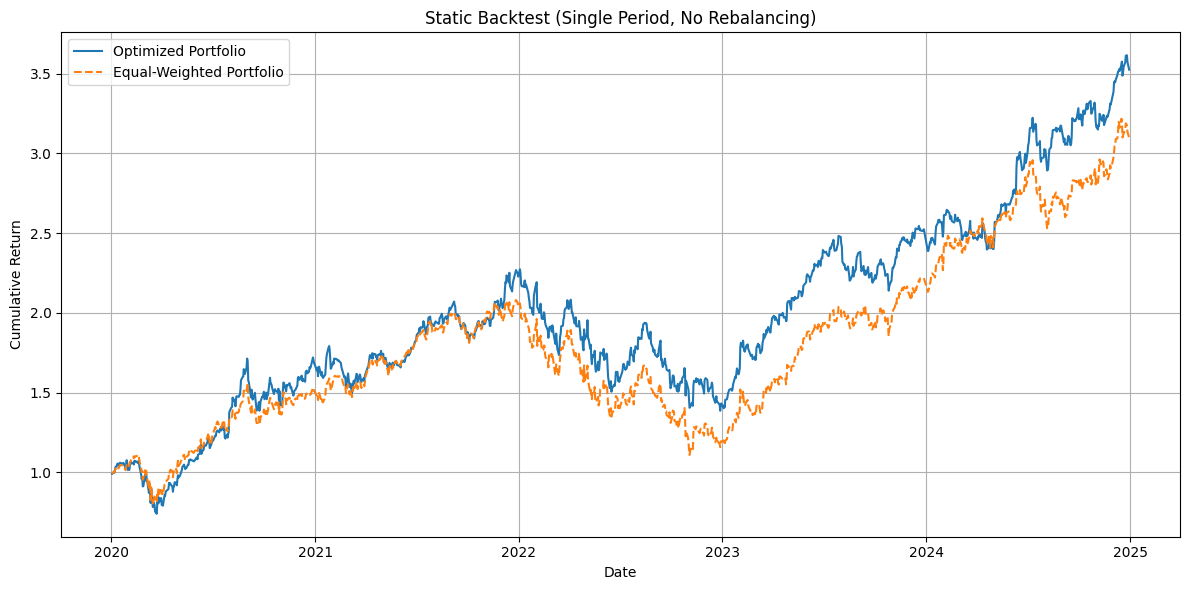

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Calculate portfolio returns
portfolio_returns = (returns @ portfolio).dropna()

# Step 2: Compute cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Step 3: Optional benchmark — equal-weighted
equal_weight = np.repeat(1/len(returns.columns), len(returns.columns))
benchmark_returns = (returns @ equal_weight).dropna()
benchmark_cumulative = (1 + benchmark_returns).cumprod()

# Step 4: Plot performance
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns, label='Optimized Portfolio')
plt.plot(benchmark_cumulative, label='Equal-Weighted Portfolio', linestyle='--')
plt.title('Static Backtest (Single Period, No Rebalancing)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [77]:
def performance_metrics(returns, rf=0.0):
    ann_return = (1 + returns.mean()) ** 252 - 1
    ann_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = (returns.mean() - rf/252) / returns.std() * np.sqrt(252)
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    return {
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

metrics = performance_metrics(portfolio_returns)
print(pd.Series(metrics))

Annualized Return        0.352408
Annualized Volatility    0.313728
Sharpe Ratio             0.962832
Max Drawdown            -0.390266
dtype: float64


## Rolling Backtest with Monthly Rebalancing (10-Day Lookback)

This dynamic backtest simulates a realistic investment strategy where the portfolio is re-optimized and rebalanced at the end of each month using the most recent 10 business days of return and factor data.

At each rebalance point:
- The Fama-French 4-factor model is refit on the latest 10-day window.
- The expected returns are calculated based on factor exposures and average factor premiums.
- A new portfolio is optimized using mean-variance techniques.
- That portfolio is then held for the next month.

This rolling framework allows the portfolio to respond to changing market conditions and evolving factor relationships, making it more adaptive than a static buy-and-hold strategy.

⚠️ This approach introduces **estimation error** from limited data (10 days), but also captures more **recent information** to drive short-term tactical adjustments.


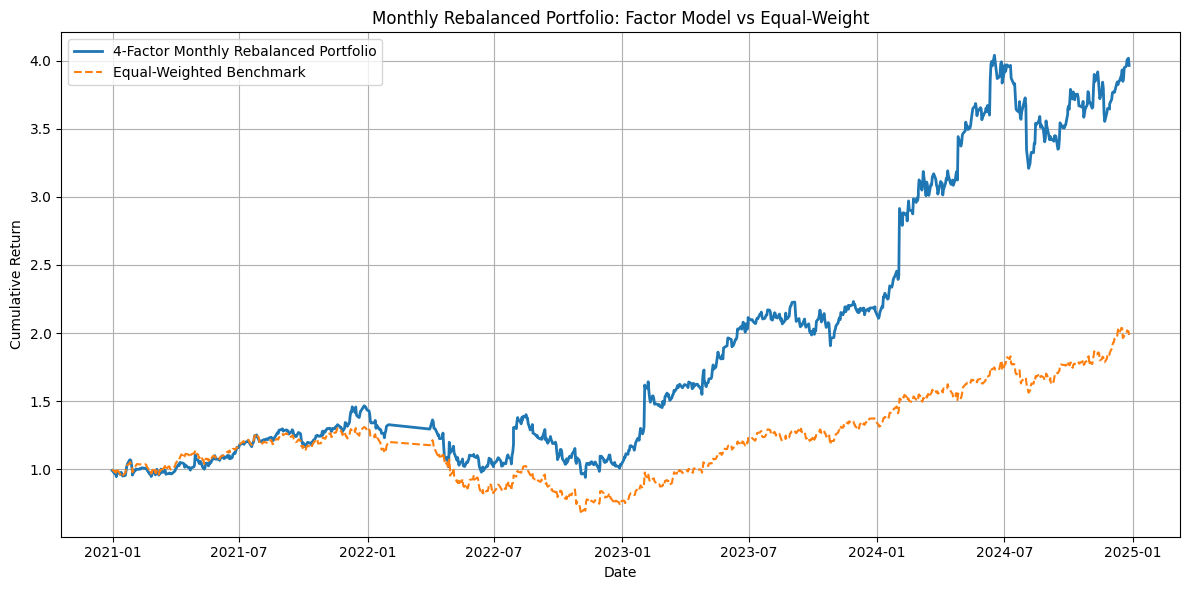

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta

# Ensure both returns and ff_factors have aligned datetime indices
common_index = returns.index.intersection(ff_factors.index)
returns = returns.loc[common_index]
ff_factors = ff_factors.loc[common_index]

# === Factor Model Optimizer ===
def portfolio_optimizer(r_window, f_window, risk_aversion=0.5):
    betas, alphas = [], []
    for ticker in r_window.columns:
        y = r_window[ticker] - f_window['RF']
        X = sm.add_constant(f_window[['Mkt-RF', 'SMB', 'HML', 'MOM']])
        model = sm.OLS(y, X).fit()
        betas.append(model.params[1:])
        alphas.append(model.params[0])

    beta_matrix = np.array(betas)
    alpha_vector = np.array(alphas)
    factor_premiums = f_window[['Mkt-RF', 'SMB', 'HML', 'MOM']].mean().values
    expected_rf = f_window['RF'].mean()
    expected_excess_returns = beta_matrix @ factor_premiums + alpha_vector
    expected_returns = expected_excess_returns + expected_rf
    cov_matrix = r_window.cov().values

    n = len(expected_returns)
    w = cp.Variable(n)
    objective = cp.Maximize(expected_returns @ w - risk_aversion * cp.quad_form(w, cov_matrix))
    constraints = [cp.sum(w) == 1, w >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return w.value if w.value is not None else None

# === Rolling Backtest ===
lookback = 10  # 2 weeks
month_ends = returns.groupby([returns.index.year, returns.index.month]).tail(1)
if len(month_ends) > lookback:
    monthly_dates = month_ends.index[lookback:]
else:
    print("⚠️ Not enough history for the selected lookback.")
    monthly_dates = pd.DatetimeIndex([])  # empty index

rebalanced_returns = []

for date in monthly_dates:
    window_start = date - pd.Timedelta(days=lookback*1.5)  # larger buffer for trading days
    r_window = returns.loc[window_start:date - pd.Timedelta(days=1)]
    f_window = ff_factors.loc[window_start:date - pd.Timedelta(days=1)]

    if len(r_window) < lookback or len(f_window) < lookback:
        continue

    weights = portfolio_optimizer(r_window, f_window)
    if weights is None:
        continue

    next_window = returns.loc[date:date + relativedelta(months=1)].dropna()
    if next_window.empty:
        continue

    portfolio_return = next_window @ weights
    rebalanced_returns.append(portfolio_return)

# === Combine and Visualize ===
if rebalanced_returns:
    rebalanced_returns = pd.concat(rebalanced_returns)
    cumulative_returns = (1 + rebalanced_returns).cumprod()

    # Calculate portfolio returns without rebalancing
    portfolio_returns = (returns @ portfolio).dropna()
    cumulative_returns_norebalance = (1 + portfolio_returns).cumprod()

    equal_weight = np.repeat(1 / returns.shape[1], returns.shape[1])
    benchmark_returns = (returns @ equal_weight).loc[rebalanced_returns.index]
    benchmark_cumulative = (1 + benchmark_returns).cumprod()

    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label='4-Factor Monthly Rebalanced Portfolio', linewidth=2)
    #plt.plot(cumulative_returns_norebalance, label='4-Factor Static No Rebalancing Portfolio', linewidth=2)
    plt.plot(benchmark_cumulative, label='Equal-Weighted Benchmark', linestyle='--')
    plt.title('Monthly Rebalanced Portfolio: Factor Model vs Equal-Weight')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [80]:
metrics = performance_metrics(cumulative_returns)
print(pd.Series(metrics))

Annualized Return        1.388718e+117
Annualized Volatility     1.542956e+01
Sharpe Ratio              3.129968e+01
Max Drawdown             -3.579449e-01
dtype: float64
